# Face Detection

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN

## Face Detection using OpenCV

In [2]:
# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image
image_path = "../data/faces/Elon.jpg" 
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the output image
cv2.imshow("Face Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Face Detection Using MTCNN

In [4]:
# Load the image
image_path = "../data/faces/Elon.jpg"
image = cv2.imread(image_path)

# Convert to RGB (MTCNN requires RGB input)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MTCNN detector
detector = MTCNN()

# Detect faces
faces = detector.detect_faces(image_rgb)

# Draw bounding boxes and landmarks
for face in faces:
    x, y, width, height = face['box']
    keypoints = face['keypoints']
    
    # Draw bounding box
    cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    # Draw facial landmarks
    for key, point in keypoints.items():
        cv2.circle(image, point, 2, (0, 0, 255), -1)

# Show the output image
cv2.imshow("MTCNN Face Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [8]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_path}")
        return None
    # Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)
    if len(faces) == 0:
        print(f"No face detected in {image_path}")
        return None

    # Use the first detected face
    x, y, width, height = faces[0]['box']
    # Ensure coordinates are non-negative
    x, y = abs(x), abs(y)
    face = image_rgb[y:y+height, x:x+width]
    face = cv2.resize(face, (160, 160))
    return face

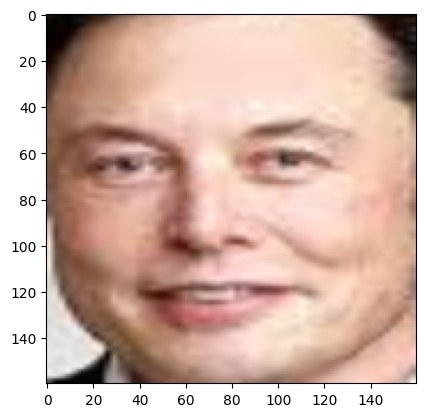

In [ ]:
image_path = "../data/faces/Elon.jpg"
plt.imshow(preprocess_image(image_path))

In [11]:
preprocess_image(image_path)

array([[[ 26,  25,  21],
        [ 25,  24,  20],
        [ 20,  19,  15],
        ...,
        [ 17,   4,   0],
        [ 17,   4,   0],
        [ 17,   4,   0]],

       [[ 23,  22,  18],
        [ 22,  21,  17],
        [ 17,  17,  12],
        ...,
        [ 25,  12,   7],
        [ 25,  12,   8],
        [ 25,  12,   8]],

       [[ 16,  16,  11],
        [ 15,  16,  11],
        [ 11,  12,   7],
        ...,
        [ 40,  27,  22],
        [ 42,  29,  23],
        [ 42,  29,  23]],

       ...,

       [[189, 189, 189],
        [188, 188, 188],
        [184, 184, 184],
        ...,
        [200, 178, 171],
        [212, 192, 186],
        [214, 194, 187]],

       [[116, 116, 116],
        [114, 114, 114],
        [ 96,  96,  96],
        ...,
        [218, 201, 193],
        [239, 224, 217],
        [241, 227, 220]],

       [[ 80,  80,  80],
        [ 77,  77,  77],
        [ 52,  52,  52],
        ...,
        [227, 212, 204],
        [252, 240, 233],
        [255, 243, 236]]

In [ ]:
'''
        try:
            emotion_result = DeepFace.analyze(face_img, actions=["emotion"], enforce_detection=False)
            if isinstance(emotion_result, list):
                dominant_emotion = emotion_result[0]["dominant_emotion"]
            else:
                dominant_emotion = emotion_result["dominant_emotion"]
        except Exception as e:
            print("Error analyzing emotion:", e)
            dominant_emotion = "Neutral"


 for (x, y, width, height, recognized_name, emotion) in recognized_faces:
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
            label = f"{recognized_name} ({emotion})"
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

'''

In [1]:
import os
import cv2
import numpy as np
import psycopg2
import logging
from deepface import DeepFace
from mtcnn import MTCNN
from dotenv import load_dotenv
from deep_sort_realtime.deepsort_tracker import DeepSort

# Set up logging for debugging and status updates.
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Load environment variables from .env
load_dotenv("../.env")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Global objects: initialize MTCNN for detection and load the FaceNet model.
detector = MTCNN()
logging.info("FaceNet model loaded successfully.")

# Initialize DeepSORT tracker (parameters can be tuned for your use case).
tracker = DeepSort()

# Global threshold (adjust this value based on your application requirements)
COSINE_THRESHOLD = 0.5

def connect_db():
    """
    Establish a persistent connection to the PostgreSQL database.
    """
    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            port=DB_PORT
        )
        logging.info("Database connection established.")
        return conn
    except Exception as e:
        logging.error("Error connecting to database: %s", e)
        return None

def find_nearest_face(conn, embedding):
    """
    Use pgvector similarity search to find the nearest face embedding stored in the database.
    
    Parameters:
        conn (psycopg2.connection): An active database connection.
        embedding (np.array): The normalized face embedding vector.
        
    Returns:
        tuple: (name, cosine_distance) if a matching face is found, else (None, None).
    """
    try:
        cursor = conn.cursor()
        # Convert embedding to a vector literal string expected by pgvector.
        embedding_str = '[' + ','.join(map(str, embedding.tolist())) + ']'
        query = """
        SELECT id, name, embedding <#> %s::vector AS cosine_distance
        FROM face_embeddings
        ORDER BY embedding <#> %s::vector
        LIMIT 1;
        """
        cursor.execute(query, (embedding_str, embedding_str))
        result = cursor.fetchone()
        cursor.close()
        if result is None:
            return None, None
        return result[1], result[2]  # name and computed cosine distance.
    except Exception as e:
        logging.error("Error in find_nearest_face: %s", e)
        return None, None

# Dictionary to hold recognized names for each track ID.
track_recognition = {}

def process_frame(frame, conn):
    """
    Process a single video frame: detect faces, extract embeddings, update tracker, and perform recognition.
    
    Returns:
        list: Each element is a tuple (x, y, width, height, recognized_name, track_id).
    """
    detections = []
    # Convert frame from BGR to RGB for processing.
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    detected_faces = detector.detect_faces(frame_rgb)
    
    for face in detected_faces:
        try:
            x, y, width, height = face['box']
            x, y = abs(x), abs(y)
            face_img = frame_rgb[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, (160, 160))
            
            # Extract embedding using the pre-loaded FaceNet model.
            result = DeepFace.represent(face_img, model_name="Facenet", enforce_detection=False)
            
            embedding = np.array(result[0]['embedding'])
            norm = np.linalg.norm(embedding)
            if norm != 0:
                embedding = embedding / norm
            else:
                continue
            
            # Use detection confidence if available; otherwise, default to 1.0.
            confidence = face.get('confidence', 1.0)
            # Prepare detection format: ([x, y, width, height], confidence, embedding vector).
            detections.append(([x, y, width, height], confidence, embedding))
        except Exception as e:
            logging.warning("Error processing detected face: %s", e)
            continue

    # Update the DeepSORT tracker with current detections.
    tracks = tracker.update_tracks(detections, frame=frame)
    
    results = []
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        bbox = track.to_ltrb()  # Format: left, top, right, bottom.
        x, y, x2, y2 = bbox
        width = x2 - x
        height = y2 - y

        # Attempt to retrieve the latest feature vector from the track.
        # Use the 'features' attribute if available (a list of features) and take the last element.
        feature = track.features[-1] if hasattr(track, 'features') and track.features else None

        if track_id not in track_recognition and feature is not None:
            name, cosine_distance = find_nearest_face(conn, feature)
            if cosine_distance is not None:
                logging.info(f"Track {track_id}: cosine distance = {cosine_distance}, name candidate = {name}")
            else:
                logging.info(f"Track {track_id}: No matching face found in database.")
            recognized_name = name if cosine_distance is not None and cosine_distance < COSINE_THRESHOLD else "Unknown"
            track_recognition[track_id] = recognized_name
        elif track_id in track_recognition:
            recognized_name = track_recognition[track_id]
        else:
            recognized_name = "Unknown"
            
        results.append((int(x), int(y), int(width), int(height), recognized_name, track_id))
    
    # Clean up recognition dictionary for tracks that are no longer present.
    current_ids = {track.track_id for track in tracks if track.is_confirmed()}
    for tid in list(track_recognition.keys()):
        if tid not in current_ids:
            del track_recognition[tid]
    
    return results

def main():
    """
    Main function to capture video, perform real-time face recognition with DeepSORT tracking,
    and display the annotated video stream.
    """
    conn = connect_db()
    if conn is None:
        logging.error("Database connection failed. Exiting.")
        return

    cap = cv2.VideoCapture(0)  # Open the default webcam.
    if not cap.isOpened():
        logging.error("Cannot open video stream.")
        return

    logging.info("Starting real-time face recognition and tracking. Press 'q' to exit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            logging.error("Failed to capture frame. Exiting...")
            break

        # Process the frame to get detections and associated track IDs.
        results = process_frame(frame, conn)
        
        # Draw bounding boxes, track IDs, and recognized names on the frame.
        for (x, y, width, height, recognized_name, track_id) in results:
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
            label = f"ID:{track_id} {recognized_name}"
            cv2.putText(frame, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)

        cv2.imshow("Real-Time Face Recognition & Tracking", frame)
        # Press 'q' to exit the loop.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    conn.close()
    cv2.destroyAllWindows()
    logging.info("Resources released. Exiting.")


2025-03-08 18:47:53,358 [INFO] FaceNet model loaded successfully.
2025-03-08 18:48:02,829 [INFO] MobileNetV2 Embedder for Deep Sort initialised
2025-03-08 18:48:02,831 [INFO] - gpu enabled: False
2025-03-08 18:48:02,832 [INFO] - half precision: False
2025-03-08 18:48:02,833 [INFO] - max batch size: 16
2025-03-08 18:48:02,834 [INFO] - expects BGR: True
2025-03-08 18:48:03,005 [INFO] DeepSort Tracker initialised
2025-03-08 18:48:03,006 [INFO] - max age: 30
2025-03-08 18:48:03,007 [INFO] - appearance threshold: 0.2
2025-03-08 18:48:03,008 [INFO] - nms threshold: OFF
2025-03-08 18:48:03,008 [INFO] - max num of appearance features: None
2025-03-08 18:48:03,009 [INFO] - overriding track class : No
2025-03-08 18:48:03,010 [INFO] - today given : No
2025-03-08 18:48:03,011 [INFO] - in-build embedder : Yes
2025-03-08 18:48:03,011 [INFO] - polygon detections : No


In [2]:
main()

2025-03-08 18:48:10,089 [INFO] Database connection established.
2025-03-08 18:48:10,855 [INFO] Starting real-time face recognition and tracking. Press 'q' to exit.
2025-03-08 18:48:18,307 [ERROR] Error in find_nearest_face: different vector dimensions 128 and 1280

2025-03-08 18:48:18,309 [INFO] Track 1: No matching face found in database.
2025-03-08 18:48:59,924 [INFO] Resources released. Exiting.
